In [13]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imread
from skimage.transform import resize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

import keras
import tensorflow as tf
from keras import backend as K
#K.set_image_dim_ordering('tf')
from keras_applications import imagenet_utils as utils
from keras_applications import correct_pad
from keras.layers import Lambda

import PIL.Image
#}

In [2]:
global start_index, end_index
start_index = end_index = 0

In [3]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [4]:
backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils
keras.backend.image_data_format()

'channels_last'

In [5]:
"""MobileNet v2 models for Keras.

MobileNetV2 is a general architecture and can be used for multiple use cases.
Depending on the use case, it can use different input layer size and
different width factors. This allows different width models to reduce
the number of multiply-adds and thereby
reduce inference cost on mobile devices.

MobileNetV2 is very similar to the original MobileNet,
except that it uses inverted residual blocks with
bottlenecking features. It has a drastically lower
parameter count than the original MobileNet.
MobileNets support any input size greater
than 32 x 32, with larger image sizes
offering better performance.

The number of parameters and number of multiply-adds
can be modified by using the `alpha` parameter,
which increases/decreases the number of filters in each layer.
By altering the image size and `alpha` parameter,
all 22 models from the paper can be built, with ImageNet weights provided.

The paper demonstrates the performance of MobileNets using `alpha` values of
1.0 (also called 100 % MobileNet), 0.35, 0.5, 0.75, 1.0, 1.3, and 1.4

For each of these `alpha` values, weights for 5 different input image sizes
are provided (224, 192, 160, 128, and 96).


The following table describes the performance of
MobileNet on various input sizes:
------------------------------------------------------------------------
MACs stands for Multiply Adds

 Classification Checkpoint| MACs (M) | Parameters (M)| Top 1 Accuracy| Top 5 Accuracy
--------------------------|------------|---------------|---------|----|-------------
| [mobilenet_v2_1.4_224]  | 582 | 6.06 |          75.0 | 92.5 |
| [mobilenet_v2_1.3_224]  | 509 | 5.34 |          74.4 | 92.1 |
| [mobilenet_v2_1.0_224]  | 300 | 3.47 |          71.8 | 91.0 |
| [mobilenet_v2_1.0_192]  | 221 | 3.47 |          70.7 | 90.1 |
| [mobilenet_v2_1.0_160]  | 154 | 3.47 |          68.8 | 89.0 |
| [mobilenet_v2_1.0_128]  | 99  | 3.47 |          65.3 | 86.9 |
| [mobilenet_v2_1.0_96]   | 56  | 3.47 |          60.3 | 83.2 |
| [mobilenet_v2_0.75_224] | 209 | 2.61 |          69.8 | 89.6 |
| [mobilenet_v2_0.75_192] | 153 | 2.61 |          68.7 | 88.9 |
| [mobilenet_v2_0.75_160] | 107 | 2.61 |          66.4 | 87.3 |
| [mobilenet_v2_0.75_128] | 69  | 2.61 |          63.2 | 85.3 |
| [mobilenet_v2_0.75_96]  | 39  | 2.61 |          58.8 | 81.6 |
| [mobilenet_v2_0.5_224]  | 97  | 1.95 |          65.4 | 86.4 |
| [mobilenet_v2_0.5_192]  | 71  | 1.95 |          63.9 | 85.4 |
| [mobilenet_v2_0.5_160]  | 50  | 1.95 |          61.0 | 83.2 |
| [mobilenet_v2_0.5_128]  | 32  | 1.95 |          57.7 | 80.8 |
| [mobilenet_v2_0.5_96]   | 18  | 1.95 |          51.2 | 75.8 |
| [mobilenet_v2_0.35_224] | 59  | 1.66 |          60.3 | 82.9 |
| [mobilenet_v2_0.35_192] | 43  | 1.66 |          58.2 | 81.2 |
| [mobilenet_v2_0.35_160] | 30  | 1.66 |          55.7 | 79.1 |
| [mobilenet_v2_0.35_128] | 20  | 1.66 |          50.8 | 75.0 |
| [mobilenet_v2_0.35_96]  | 11  | 1.66 |          45.5 | 70.4 |

The weights for all 16 models are obtained and
translated from the Tensorflow checkpoints
from TensorFlow checkpoints found [here]
(https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/README.md).

# Reference

This file contains building code for MobileNetV2, based on
[MobileNetV2: Inverted Residuals and Linear Bottlenecks]
(https://arxiv.org/abs/1801.04381) (CVPR 2018)

Tests comparing this model to the existing Tensorflow model can be
found at [mobilenet_v2_keras]
(https://github.com/JonathanCMitchell/mobilenet_v2_keras)
"""
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import warnings
import numpy as np

# TODO Change path to v1.1
BASE_WEIGHT_PATH = ('https://github.com/JonathanCMitchell/mobilenet_v2_keras/'
                    'releases/download/v1.1/')

backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils


def preprocess_input(x, **kwargs):
    """Preprocesses a numpy array encoding a batch of images.

    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].

    # Returns
        Preprocessed array.
    """
    return utils.preprocess_input(x, mode='tf', **kwargs)


# This function is taken from the original tf repo.
# It ensures that all layers have a channel number that is divisible by 8
# It can be seen here:
# https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def MobileNetV2(input_shape=None,
                alpha=1.0,
                include_top=True,
                weights='imagenet',
                input_tensor=None,
                pooling=None,
                classes=1000,
                lambda_mask = None,
                **kwargs):
    """Instantiates the MobileNetV2 architecture.

    # Arguments
        input_shape: optional shape tuple, to be specified if you would
            like to use a model with an input img resolution that is not
            (224, 224, 3).
            It should have exactly 3 inputs channels (224, 224, 3).
            You can also omit this option if you would like
            to infer input_shape from an input_tensor.
            If you choose to include both input_tensor and input_shape then
            input_shape will be used if they match, if the shapes
            do not match then we will throw an error.
            E.g. `(160, 160, 3)` would be one valid value.
        alpha: controls the width of the network. This is known as the
        width multiplier in the MobileNetV2 paper, but the name is kept for
        consistency with MobileNetV1 in Keras.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of
            `layers.Input()`)
            to use as image input for the model.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape or invalid alpha, rows when
            weights='imagenet'
    """
    global backend, layers, models, keras_utils, debug
    debug = False
    backend= keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` '
                         'as true, `classes` should be 1000')

    # Determine proper input shape and default size.
    # If both input_shape and input_tensor are used, they should match
    if input_shape is not None and input_tensor is not None:
        try:
            is_input_t_tensor = backend.is_keras_tensor(input_tensor)
        except ValueError:
            try:
                is_input_t_tensor = backend.is_keras_tensor(
                    keras_utils.get_source_inputs(input_tensor))
            except ValueError:
                raise ValueError('input_tensor: ', input_tensor,
                                 'is not type input_tensor')
        if is_input_t_tensor:
            if backend.image_data_format == 'channels_first':
                if backend.int_shape(input_tensor)[1] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
            else:
                if backend.int_shape(input_tensor)[2] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
        else:
            raise ValueError('input_tensor specified: ', input_tensor,
                             'is not a keras tensor')

    # If input_shape is None, infer shape from input_tensor
    if input_shape is None and input_tensor is not None:

        try:
            backend.is_keras_tensor(input_tensor)
        except ValueError:
            raise ValueError('input_tensor: ', input_tensor,
                             'is type: ', type(input_tensor),
                             'which is not a valid type')

        if input_shape is None and not backend.is_keras_tensor(input_tensor):
            default_size = 224
        elif input_shape is None and backend.is_keras_tensor(input_tensor):
            if backend.image_data_format() == 'channels_first':
                rows = backend.int_shape(input_tensor)[2]
                cols = backend.int_shape(input_tensor)[3]
            else:
                rows = backend.int_shape(input_tensor)[1]
                cols = backend.int_shape(input_tensor)[2]

            if rows == cols and rows in [96, 128, 160, 192, 224]:
                default_size = rows
            else:
                default_size = 224

    # If input_shape is None and no input_tensor
    elif input_shape is None:
        default_size = 224

    # If input_shape is not None, assume default size
    else:
        if backend.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [96, 128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = 224

    input_shape = utils._obtain_input_shape(input_shape,
                                      default_size=default_size,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if backend.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if alpha not in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of `0.35`, `0.50`, `0.75`, '
                             '`1.0`, `1.3` or `1.4` only.')

        if rows != cols or rows not in [96, 128, 160, 192, 224]:
            rows = 224
            warnings.warn('`input_shape` is undefined or non-square, '
                          'or `rows` is not in [96, 128, 160, 192, 224].'
                          ' Weights for input shape (224, 224) will be'
                          ' loaded as the default.')

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = layers.ZeroPadding2D(padding=correct_pad(backend, img_input, 3),
                             name='Conv1_pad')(img_input)
    x = layers.Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(x)
    global start_index, end_index
    start_index = end_index = 0
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (default_size//2 * default_size//2 * first_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (default_size//2, default_size//2, first_block_filters))
        if debug:
            print('Conv_1',start_index,end_index)
    else:
        x_mask = np.ones(shape=((default_size//2, default_size//2, first_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (default_size//2 * default_size//2 * first_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (default_size//2, default_size//2, first_block_filters))
        if debug:
            print('Conv_1_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((default_size//2, default_size//2, first_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=10, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=11, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=12, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16, lambda_mask=lambda_mask)

    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = layers.Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (x.shape[1] * x.shape[2]* last_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (x.shape[1], x.shape[2], last_block_filters))
        if debug:
            print('Conv_1',start_index,end_index)
    else:
        x_mask = np.ones(shape=((x.shape[1], x.shape[2], last_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (x.shape[1] * x.shape[2] * last_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (x.shape[1], x.shape[2], last_block_filters))
        if debug:
            print('Conv_1_bn',start_index,end_index)
    else:
        x_mask = np.ones(shape=((x.shape[1],x.shape[2], last_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.ReLU(6., name='out_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(classes, activation='softmax', use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name='mobilenetv2_%0.2f_%s' % (alpha, rows))

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' + str(alpha) + '_' + str(rows) + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        else:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' + str(alpha) + '_' + str(rows) + '_no_top' + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, lambda_mask = None):
    global debug
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
    in_channels = backend.int_shape(inputs)[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)
    #print(prefix, inputs.shape,inputs.shape[0],inputs.shape[1] , in_channels, pointwise_conv_filters, pointwise_filters, filters)
    global start_index, end_index
    if block_id:
        # Expand
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (inputs.shape[1] * inputs.shape[2] * inputs.shape[3]*expansion)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion))
            if debug:
                print(prefix + 'expand',start_index,end_index)
        else:
            x_mask = np.ones(shape=((inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################
        x = layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
  
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (inputs.shape[1] * inputs.shape[2] * inputs.shape[3]*expansion)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion))
            if debug:
                print(prefix + 'expand_BN',start_index,end_index)
        else:
            x_mask = np.ones(shape=((inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = layers.ZeroPadding2D(padding=correct_pad(backend, x, 3), name=prefix + 'pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, activation=None, use_bias=False,padding='same' if stride == 1 else 'valid', name=prefix + 'depthwise')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * inputs.shape[3]*expansion)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion))
        if debug:
            print(prefix + 'depthwise',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,epsilon=1e-3,momentum=0.999, name=prefix + 'depthwise_BN')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * inputs.shape[3]*expansion)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion))
        if debug:
            print(prefix + 'depthwise_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = layers.Conv2D(pointwise_filters, kernel_size=1, padding='same', use_bias=False, activation=None, name=prefix + 'project')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * pointwise_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters))
        if debug:
            print(prefix + 'project',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis, epsilon=1e-3, momentum=0.999, name=prefix + 'project_BN')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * pointwise_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters))
        if debug:
            print(prefix + 'project_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x

In [6]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        '''
        img = imread(im_path,as_gray=False, pilmode="RGB")
        #print im_path
        #print img.shape
        if img_size:
            img = resize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)
        '''
        size = 224
        ret = PIL.Image.open(im_path)
        ret = ret.resize((size, size))
        ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
        if ret.ndim == 2:
            ret.resize((size, size, 1))
            ret = np.repeat(ret, 3, axis=-1)
        #ret = ret.transpose((2, 0, 1))
        #ret = np.flip(ret,0)
        global backend
        x = preprocess_input(ret, 
            data_format=backend.image_data_format())
        img_list.append(x)


    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [7]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [8]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [9]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

In [10]:
model_name = 'MobileNetV2'
'''
model = MobileNetV2( input_shape=None,
    alpha=0.35,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")
'''

'\nmodel = MobileNetV2( input_shape=None,\n    alpha=0.35,\n    include_top=True,\n    weights="imagenet",\n    input_tensor=None,\n    pooling=None,\n    classes=1000,\n    classifier_activation="softmax")\n'

In [ ]:
import gc
K.image_data_format()
keras.backend.clear_session()
gc.collect()
del model

In [22]:
#%%time
#Testing on test data{
data_path = '../../data/pkl_mobile/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/pkl_mobile/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/pkl_mobile/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=65827,
                             random_state=0,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/pkl_mobile/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

#DO CLUSTERING AND GET CLUSTERS

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
#import genieclust
#import hdbscan
#import smm

j = 28  #Set this value from scree plot!
method = 'GMM'
print(j)
#clf = hdbscan.HDBSCAN(min_cluster_size=j, gen_min_span_tree=True)
#clf = DBSCAN(eps=5.443)
#clf = KMeans(n_clusters=j,random_state=143)
#clf= SpectralClustering(n_clusters=j,random_state=143)
#clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
#clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
clf = GaussianMixture(n_components=j, covariance_type='full',random_state=143)
#clf= genieclust.genie.Genie(n_clusters=j)
#clf= smm.SMM(n_components=j, covariance_type='full', random_state=143, tol=1e-12,min_covar=1e-6, n_iter=1000, n_init=1, params='wmcd', init_params='wmcd')
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
#y_pred = clf.fit_predict(X_new)
print(set(y_pred))
#Z = clf.predict(X)

for label in set(y_pred):
    print('Cluster: ',j,'Label: ', label)

    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)
    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl_mobile/'+p+'_MobileNetV2_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    keras.backend.clear_session()
    gc.collect()
    del model

    result[label] = dprime

28
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}
Cluster:  28 Label:  0
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cluster:  28 Label:  1
animate 7 39 0.8205128205128205 0.17948717948717952
inanimate 24 39 0.3846153846153846 0.6153846153846154
Cluster:  28 Label:  2
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cluster:  28 Label:  3
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cluster:  28 Label:  4
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cluster:  28 Label:  5
animate 17 39 0.5641025641025641 0.4358974358974359
inanimate 22 39 0.4358974358974359 0.5641025641025641
Cluster:  28 Label:  6
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  28 Label:  7
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  28 Label:  8
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cluster:  28 Label:  9
animate 0 39 1.0

In [23]:
list(result.values()),X.shape

([0.0,
  0.4358974358974359,
  0.0,
  0.0,
  0.0,
  0.1282051282051282,
  -0.07692307692307698,
  -0.05128205128205132,
  0.0,
  0.20512820512820507,
  -0.02564102564102566,
  0.15384615384615385,
  0.0,
  0.0,
  0.02564102564102555,
  -0.02564102564102566,
  0.46153846153846156,
  0.3846153846153846,
  0.0,
  0.05128205128205132,
  -0.2564102564102564,
  0.0,
  -0.07692307692307687,
  0.05128205128205132,
  0.05128205128205132,
  0.0,
  0.0,
  0.1282051282051282],
 (5725552, 2))

In [24]:
z_temp = []
for item in y_pred:
    z_temp.append(result[item])
print(len(z_temp),len(X_new))
loc_z = kmeans.predict(X_new)
z = np.ones(shape=((5725552,)))
for i in range(len(loc_z)):
    temp = np.where(pred_kmeans==loc_z[i])[0]
    z[temp] = z_temp[i]

65827 65827


In [25]:
x = X[:,0]
y = X[:,1]

In [26]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))
ana = int(list(result.values()).index(max(result.values())))
ina = int(list(result.values()).index(min(result.values())))
print(result[ana], -1*(result[ina]))

16 20
0.46153846153846156 0.2564102564102564


(5725552,) (5725552,) (5725552,)


Text(0.5, 1.0, 'Performance Impact - Density plot')

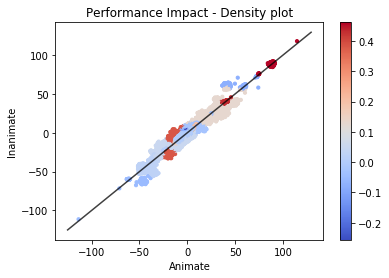

In [27]:
#Density Plot for Animate/Inanimate

print(x.shape,y.shape,z.shape)
fig, ax = plt.subplots()
cs = ax.scatter(x, y, c=z, s=10,cmap='coolwarm')
cbar = fig.colorbar(cs)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75)
plt.xlabel('Animate')
plt.ylabel('Inanimate')
plt.title('Performance Impact - Density plot')
#plt.savefig('../../results/'+str(method)+'_results_density.png', format='png',dpi=200)